In [44]:
import matplotlib.pyplot as plt

# from config import settings

import pymongo
%matplotlib inline


# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Sep10_encoding']

from joblib import Parallel, delayed, Memory


mem = Memory('/tank/kuntai/joblib_cache',verbose=0)



plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 35
plt.rcParams['pdf.fonttype'] = 42
colors = [
    "#1F4690", # oneadapt
    "#576F72", # baseline 1
    "#850E35", # baseline 2
    "#614124", # baseline 3
]
bandwidth = 10 * 1000 * 1000 / 8 # 10 Mbps
inference = 0.05
latency = 0.03 # 30ms network latency

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fig.savefig(f'{filename}_time_{timestr}.pdf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')


In [40]:
@mem.cache
def single_query(query):
    x = list(db['examine'].find(query))
    x = sorted(x, key = lambda x: x['_id'])
    return x[-1]
    



@mem.cache
def query_approach(fmt, approach="", column='stats'):
    
    try:
        stats = []

        stats = Parallel(n_jobs=4,prefer='threads')(delayed(single_query)({
                'my_args.second': sec,
                'my_args.command_line_args.approach': approach,
                'my_args.input': fmt,
            }) for sec in range(0, 119))

        return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    except IndexError as e:
        print(fmt)
        print(approach)
        raise e
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

[4.27199405e+05 8.90801554e-01]
[1.05121987e+05 7.68163236e-01]
[1.52330121e+05 8.06327368e-01]
[3.15339554e+05 8.69175045e-01]
[6.76653264e+05 9.18710309e-01]
[1.99851127e+05 8.24781280e-01]
233
[6.26481724e+05 9.18380741e-01]
[1.47045744e+05 7.69376142e-01]
[6.34714811e+05 9.18124752e-01]
[1.75060977e+05 7.89004795e-01]
[7.42198923e+05 9.23335886e-01]
[3.10604301e+05 8.33986165e-01]
[2.24031425e+05 8.04176513e-01]
[2.69721629e+05 8.20347698e-01]
[3.29677364e+05 8.35060877e-01]
[2.18489849e+05 8.02663672e-01]
[2.15925921e+05 8.01292460e-01]


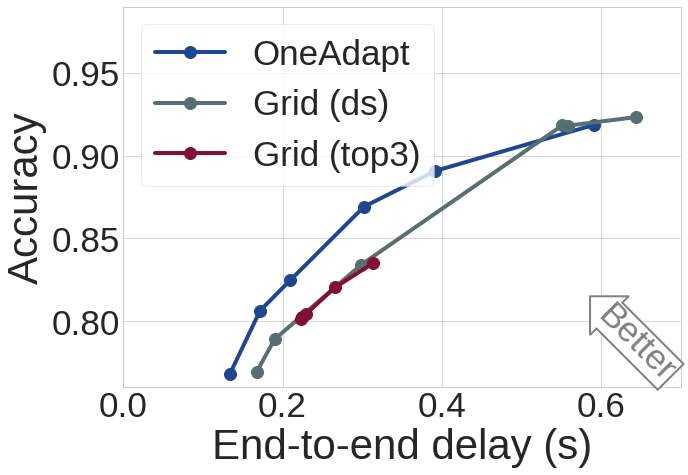

In [66]:


import numpy as np
idxs = list(range(10))
# idxs = list(range(1))
# idxs = [9]
# # 3, 7, 8


fig, ax = plt.subplots(figsize=(10, 7))

x = []
lr = 0.5
for bw_weight in [0.0002, 0.0018 , 0.0009 , 0.0003, 0.0001, 0.0006,]:

    y = []
    

    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f'oneadapt_encoding_{bw_weight}_lr_{lr}'))
        
    print(np.mean(y, axis=0))

    x.append(np.mean(y, axis=0))
    
x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference for i in x], [i[1] for i in x], label='OneAdapt', c=colors[0], marker='o', linewidth=4, markersize=12)


print(233)

x=[]
for bw_weight in [2.4, 0.8,  0.2]:


    for downsample_factor in [3,2]:


    
        y = []


        for idx in idxs:
            fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

            y.append(query_approach(fmt, f'immediate_chameleon_{downsample_factor}x_bwweight_{bw_weight}'))
        y = np.array(y)

        print(np.mean(y, axis=0))

        x.append(np.mean(y, axis=0))


x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference for i in x], [i[1] for i in x], label='Grid (ds)', c=colors[1], marker='o', linewidth=4, markersize=12)


x=[]
for bw_weight in [0.8, 0.4, 0.2, 1.6, 2.5]:


    y = []

    
    for idx in idxs:
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'immediate_chameleon_top3_bwweight_{bw_weight}'))
    y = np.array(y)
    
    print(np.mean(y, axis=0))

    x.append(np.mean(y, axis=0))

x = sorted(x, key = lambda i: i[0])
ax.plot([i[0]/bandwidth+inference for i in x], [i[1] for i in x], label='Grid (top3)', c=colors[2], marker='o', linewidth=4, markersize=12)


l, r = 0, 0.7
b, u = 0.76, 0.99
# b, u = 0.5, 0.99

ax.set_xlim(l,r)
ax.set_ylim(b,u)
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('End-to-end delay (s)')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props, c='grey')

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

ax.legend(loc=2,frameon=True)

In [49]:
savefig('/home/kuntai/paper/DiffAdapt-HotNets/figs/tradeoff-RGB-encoding-knobs', fig)

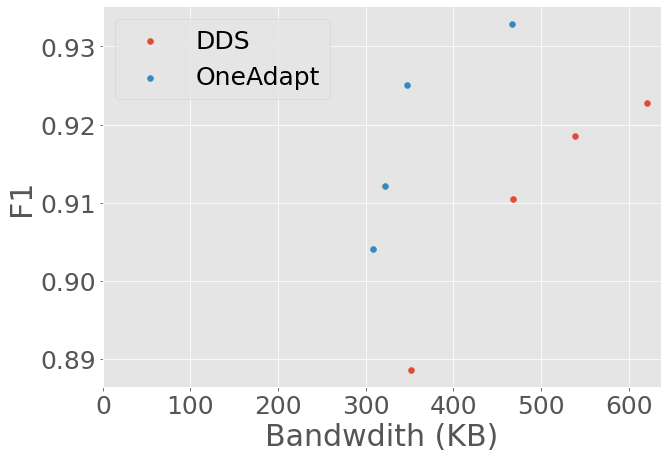

In [10]:
 

import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_0/part%d.mp4'
def query_approach(fmt, approach="", column='stats'):
    stats = []


    for sec in range(0, 180):

        query = {
            'my_args.second': sec,
            'my_args.command_line_args.approach': approach,
            'my_args.input': fmt,
        }
        
        # if isinstance(approach, dict):
        #     del query['command_line_args.approach']
        #     query['input'] = query['command_line_args.input']
        #     del query['command_line_args.input']
        #     query.update(approach)
        #     print(query)

        x = list(db['examine'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        stats.append(x[-1])

    return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, ax = plt.subplots(figsize=(10, 7))





x = []


import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_0/part%d.mp4'
def query_approach(fmt, approach="", column='stats'):
    stats = []


    for sec in range(0, 180):

        query = {
            'my_args.second': sec,
            'my_args.command_line_args.approach': approach,
            'my_args.input': fmt,
        }
        
        # if isinstance(approach, dict):
        #     del query['command_line_args.approach']
        #     query['input'] = query['command_line_args.input']
        #     del query['command_line_args.input']
        #     query.update(approach)
        #     print(query)

        x = list(db['examine'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        stats.append(x[-1])

    return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, ax = plt.subplots(figsize=(10, 7))





x = []
for lq in [32, 30, 28, 36]:

    y = []

    for idx in range(10):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"dds_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='DDS')


x=[]
for thresh in [0.00625,0.0125, 0.05, 0.2]:
    
    y = []

    
    for idx in range(10):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'oneadapt_macroblock_thresh_{thresh}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='OneAdapt')


ax.set_xlabel('Bandwdith (KB)')
ax.set_ylabel('F1')
ax.set_xlim(left=0)

    y = []

    for idx in range(1):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"dds_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='DDS')


x=[]
for thresh in [0.00625,0.0125, 0.05, 0.2]:
    
    y = []

    
    for idx in range(1):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'oneadapt_macroblock_thresh_{thresh}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='OneAdapt')


ax.set_xlabel('Bandwdith (KB)')
ax.set_ylabel('F1')
ax.set_xlim(left=0)
ax.legend()

0.0648665301529331 0.7293657311274729
0.08506145258921027 0.789334231188738


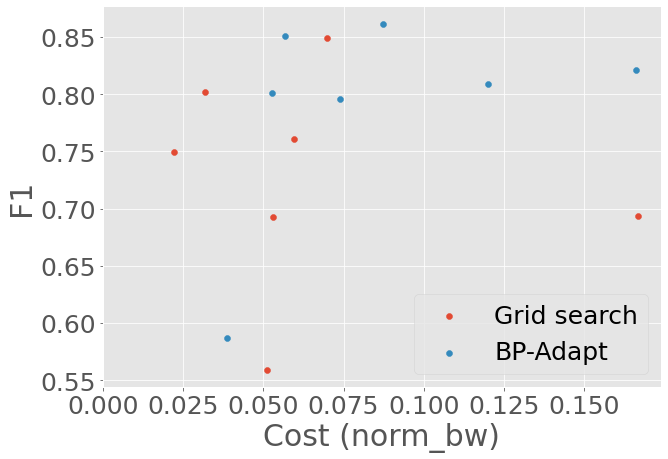

In [9]:
def calc_cost_chameleon(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['cost'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

def calc_cost_backprop(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue
            
            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])
            
            if sec % 3 == 0 and sec < 20:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10 + 0.1
            else:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

fig, ax = plt.subplots(figsize=(10, 7))

compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_chameleon('chameleon', fmt))
    bw.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'norm_bw'))
    acc.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='Grid search')

print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))


compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_backprop(approach1, fmt))
    bw.append(calc_cost_backprop(approach1, fmt, cost_key='norm_bw'))
    acc.append(calc_cost_backprop(approach1, fmt, cost_key='f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='BP-Adapt')
print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))

ax.set_xlim(left=0)
ax.set_xlabel('Cost (norm_bw)')
ax.set_ylabel('F1')

ax.legend()